### Téléchargement des données
Nous utiliserons, dans nos expériences, la base de données `Cifar-10` qui regroupe des images représentants 10 types d’objets diﬀérents (chien, camion, avion, ...). Cette base est disponible à l’url : http://www.cs.toronto.edu/~kriz/cifar.html.<br>
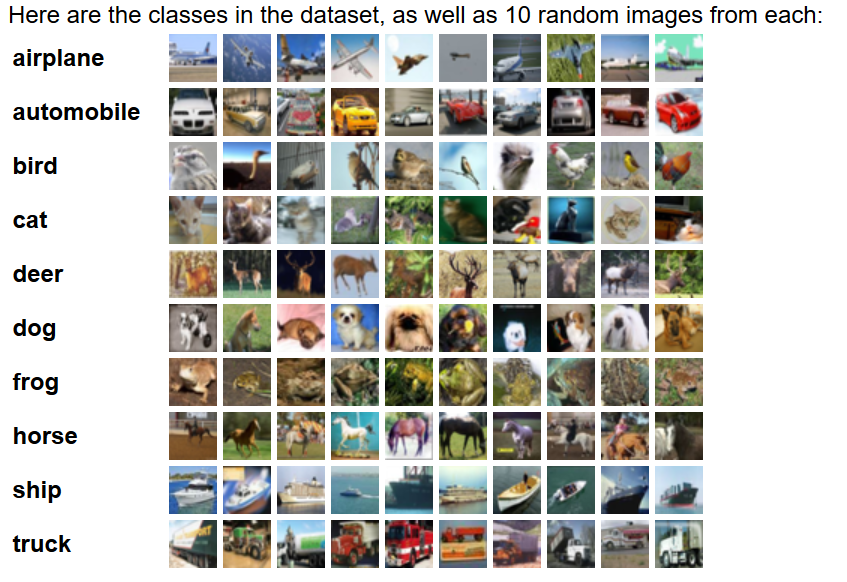


In [9]:
from keras.utils.data_utils import get_file
import tarfile

try:
    path = get_file('cifar-10-python.tar.gz', origin='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
except:
    print('Erreur de téléchargement, Veillez le télécharger manuellement'
          '$ wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz\n'
          '$ mv cifar-10-python.tar.gz .keras/datasets/'
          '$ cp /home/hasmiou/.keras/datasets/cifar-10-python.tar.gz /mnt/d/Master1S2/IA/Projet')
    raise

In [10]:
#%cp /home/hasmiou/.keras/datasets/cifar-10-python.tar.gz /mnt/d/Master1S2/IA/Projet

### Décompression des données
Nous allons utiliser la fonction fournie dans le site Kriz pour décompresser les données, on lui donne un nom de fichier et il rend un dictionnaire comportant les différentes classe de données.

In [11]:
import numpy as np
import math
from random import randrange
import pickle
import time

def unpickle(file):
    '''
    La fonction unpickle prend en argument un nom de fichier et retourne un dictionnaire
    '''
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [12]:
#%tar xvf cifar-10-python.tar.gz cifar-10-python
train_set_1 = unpickle("cifar-10-python/cifar-10-batches-py/data_batch_1")
train_set_2 = unpickle("cifar-10-python/cifar-10-batches-py/data_batch_2")
train_set_3 = unpickle("cifar-10-python/cifar-10-batches-py/data_batch_3")
train_set_4 = unpickle("cifar-10-python/cifar-10-batches-py/data_batch_4")
train_set_5 = unpickle("cifar-10-python/cifar-10-batches-py/data_batch_5")
test_set = unpickle("cifar-10-python/cifar-10-batches-py/test_batch")

# Apprentissage
On va observer les données du train_set_1 pour alléger l'apprentissage du programme en récupérant les labels et les données.
Nous devons commencer par nous familiariser avec le format de la base
1. Comment sont stockées les données
2. Le type des images représentées
3. Est-ce que la tâche est difficile pour un humain? pour un ordinateur?
4. Quel taux d’erreur peut-on espérer atteindre? ...
5. Les statistiques « générales » du jeu de données (combien y a-t-il de classes ? d’exemples par classe ? ...).


In [13]:
#print("Les données d'apprentissage sont: ",train_set_1)
#print("Les données de test sont: ",test_set)

In [14]:
print ("Le type des données d'apprentissage est ",type(train_set_1))
print ("Le type des données de test est  ",type(test_set))

Le type des données d'apprentissage est  <class 'dict'>
Le type des données de test est   <class 'dict'>


In [15]:
print ("La taille des données: ",len(train_set_1[b'data']))
print ("Type de données : ",type(train_set_1[b'data']))

print ("La tailles des étiquetes:",len(train_set_1[b'labels']))
print ("Type des étiquetes:",type(train_set_1[b'labels']))

print ("La taille des noms de fichiers: ",len(train_set_1[b'filenames']))
print ("Type de noms de fichiers :", type(train_set_1[b'filenames']))

La taille des données:  10000
Type de données :  <class 'numpy.ndarray'>
La tailles des étiquetes: 10000
Type des étiquetes: <class 'list'>
La taille des noms de fichiers:  10000
Type de noms de fichiers : <class 'list'>


In [16]:
X_train_1=train_set_1[b'data']
Y_train_1=train_set_1[b'labels']

X_test=test_set[b'data']
Y_test=test_set[b'labels']

data_size=len(train_set_1[b'data'])

print ("La taille d'une seule image : ", len(X_train_1[1]))
print ("Le type d'une seule image : ",type(X_train_1[1]))

La taille d'une seule image :  3072
Le type d'une seule image :  <class 'numpy.ndarray'>


## Approche naïve K-Means

In [17]:
def countLabel(label):
    """
    La fonction prend des données et compte le nombre de label distinct contenu dans ces données
    """
    l=[]
    k=0
    for i in label:
        if i not in l:
            l.append(i)
            k+=1
    return k

In [18]:
k = countLabel(Y_train_1)
print("Dans ces données d'apprentissage il existe ",k , "labels distincts")

Dans ces données d'apprentissage il existe  10 labels distincts


In [19]:
def random_cluster_center(k,data_set):
    centroids=np.zeros(shape=(k,len(data_set[0])))
    for i in range(len(data_set[0])):
        smaller_i = min(data_set[:,i])
        largest_i = max(data_set[:,i])
        for index in range(k):
            centroids[index][i]=smaller_i + (largest_i-smaller_i)*(index+1)/float(k)
    return centroids


d(x, y) = &radic; (x1 − y1) 2 + (x2 − y2)


In [20]:
def distEclud(variable,cluster):
    """
    Calcul de la distance eucludienne entre deux points
    """
    return np.sqrt(np.sum(np.power(variable-cluster,2)))

In [21]:
import operator
def getLabel(label_set):
    label_dic={}
    for i in range(len(label_set)):
        label=label_set[i]
        if label not in label_dic :
            label_dic[label]=1
        else:
            label_dic[label]+=1
    return max(label_dic.items(), key=operator.itemgetter(1))[0]

In [22]:
def kMean(data_set,k,label_set):
    centroids=random_cluster_center(k,data_set)
    print("Nombre de cluster ",len(centroids))
    pre_labels=np.zeros(len(data_set))
    k2label=np.zeros(k)
    
     #prend data_set, centroids, pr_label, 
    convege=False
    model_centroids=[]
    while not convege:
        convege=True
        for i in range(len(data_set)):
            image=data_set[i]
            mindis=np.inf
            label=-1
            for j in range(k):
                distance=distEclud(image,centroids[j])
                if distance<mindis:
                    mindis=distance
                    label=j
            if pre_labels[i]!=label:
                convege=False
            pre_labels[i]=label
        
        for i in range(k):
            label_i_images=data_set[pre_labels==i]
            mean=label_i_images.mean(axis=0)
            centroids[i]=mean
            
            #prend k, label-set, pre_ rend model_centroids
    for i in range(k):
        label_set=np.asarray(label_set)
        label_i_index=label_set[pre_labels==i]
        major_label=getLabel(label_i_index)
        k2label[i]=major_label
        model_centroids.append((centroids[i],k2label[i]))
    print ("Taille du model d'apprentissage ",len(model_centroids))
    return model_centroids

In [23]:
train_model=kMean(X_train_1,k,Y_train_1)
print ("Type du model: ",type(train_model))
print ("Model d'apprentissage crée avec  succes")

Nombre de cluster  10
Taille du model d'apprentissage  10
Type du model:  <class 'list'>
Model d'apprentissage crée avec  succes


In [24]:
def evaluate(train_model,X_test,Y_test):
    Y_test=np.asarray(Y_test)
    mistake=[]
    acc=0
    for i in range(len(X_test)):
        mindis=np.inf
        image=X_test[i]
        label=-1
        for j in range(len(train_model)):
            distance=distEclud(image,train_model[j][0])
            if distance<mindis:
                mindis=distance
                label=train_model[j][1]
        if label!=Y_test[i]:
            mistake.append(i)
        else:
            acc+=1
    return acc,mistake

In [25]:
acc,mistake=evaluate(train_model,X_test,Y_test)

def rate(a,t, sign = False):
       return a/float(len(t))
    
print ("Performance: ",rate(acc,X_test)*100.0,"%")
print ("Les mauvais numéro du test: ",mistake)

Performance:  22.05 %
Les mauvais numéro du test:  [0, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 17, 19, 20, 22, 23, 24, 27, 28, 31, 32, 33, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 93, 94, 95, 96, 97, 99, 100, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 123, 125, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 139, 140, 141, 142, 143, 145, 147, 148, 149, 151, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 165, 167, 168, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 184, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212, 214, 216, 217, 218, 219, 221, 222, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 25

### Conclusion
Notre algorithme <b>K-means</b> n'est pas meuilleur. La precision est dans les environs de <b>20%</b>. Nus avons choisis d'utiliser la distance d'ecludienne pour définir la distance entre chaque point.<br>
Pour obtenir le modèle, il me faut environ 15 ~ 20 minutes, c'est long et le résultat est de faible efficacité.


In [26]:
from sklearn.cluster import KMeans 
K=25
print ("Start creating the dictionary")
print ("Start using the sklearn Kmeans....")
result = KMeans(n_clusters=K).fit(X_train_1)
print ("K-means has done...")

Start creating the dictionary
Start using the sklearn Kmeans....
K-means has done...


In [73]:
train_cluster_labels=result.predict(X_train_1)
test_cluster_labels=result.predict(X_test)

In [74]:
def new_create_dictionary(train_cluster_labels,test_cluster_labels):
    train_dic=[]
    test_dic=[]
    for i in range(len(train_cluster_labels)):
        train_dic.append(np.zeros(K))
    for i in range(len(test_cluster_labels)):
        test_dic.append(np.zeros(K))
    for i in range(len(train_cluster_labels)):
        cluster=train_cluster_labels[i]
        train_dic[i][cluster]=1
    for i in range(len(test_cluster_labels)):
        cluster=test_cluster_labels[i]
        test_dic[i][cluster]=1
    train_dic=np.asarray(train_dic)
    test_dic=np.asarray(test_dic)
    return train_dic,test_dic

In [75]:
train_dic,test_dic=new_create_dictionary(train_cluster_labels,test_cluster_labels)

In [78]:
from sklearn.svm import SVC
print ("using the SVC to do the classifier:")
model=SVC()
model=model.fit(train_dic,Y_train_1)

print ("model compeleted")

using the SVC to do the classifier:
model compeleted


In [81]:
print (model.score(test_dic,Y_test)*100.0,"%")

26.7 %
